<strong><span style="font-size: 40px;">**Teste AnOVa**</span></strong>

# <strong><span style="font-size: 28px;">**"Santa Claus Rally" e "Efeito Janeiro"**</span></strong>

<span style="font-size: 20px;">Além do famoso "Sell in May and go away", outros dois padrões sazonais que intrigam os investidores são o "Santa Claus Rally" e o "Efeito Janeiro". O "Santa Claus Rally" refere-se ao aumento dos preços das ações nos últimos dias de dezembro e primeiros dias de janeiro. O "Efeito Janeiro" sugere que janeiro costuma ter um desempenho mais forte em comparação com outros meses do ano.</span>

---

Preparação dos dados

- Baixar dados do IBOV
- Preparar os dados
- Adicionar informações de mês e ano

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import plotly.graph_objects as go
from scipy import stats
import pingouin as pg

ibov_ohlc = yf.download('^BVSP', period='max', interval='1d')

ibov_ohlc = ibov_ohlc.resample('ME').agg({"Open": "first", "High": "max", "Low": "min", "Close": "last"})
ibov_ohlc['Resultado_mes'] = (ibov_ohlc['Close'].pct_change() * 100).round(2)

ibov_ohlc["Mes"] = ibov_ohlc.index.month_name()
ibov_ohlc["Ano"] = ibov_ohlc.index.year
ibov_ohlc["Mes_num"] = ibov_ohlc.index.strftime('%m')
ibov_ohlc = ibov_ohlc.loc['2000':'2023']

ibov_ohlc

Pivot Table média de todos os anos

In [ ]:
resultado_geral = pd.pivot_table(ibov_ohlc, values="Resultado_mes", index=["Mes_num"], columns=[], aggfunc="mean")
resultado_geral = resultado_geral.style.format('{:.3f}', na_rep="").map(lambda x: 'background-color : #023E2E' if x > 0 else 'background-color : #6b2223')

display(resultado_geral)


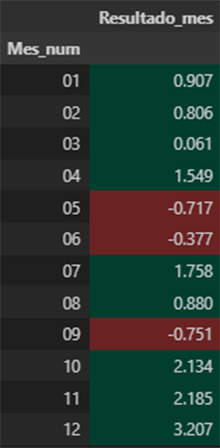
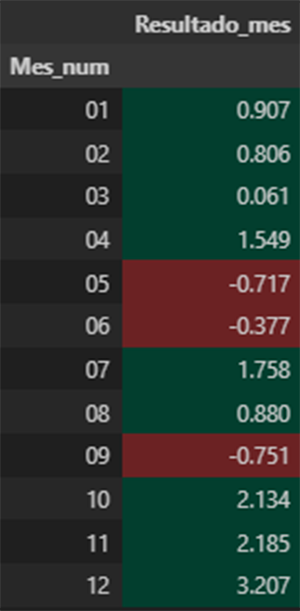
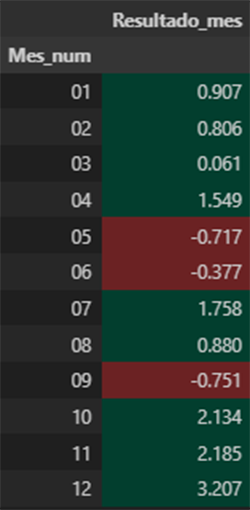
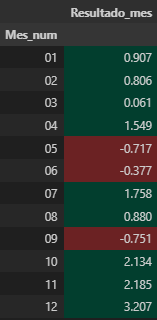

Pivot Table por ano

In [ ]:
td_anos = pd.pivot_table(ibov_ohlc, values="Resultado_mes", index=["Ano"], columns=["Mes_num"], aggfunc="mean")
td_anos = td_anos.style.format('{:.3f}', na_rep="").map(lambda x: 'background-color : #023E2E' if x > 0 else 'background-color : #6b2223')

display(td_anos)

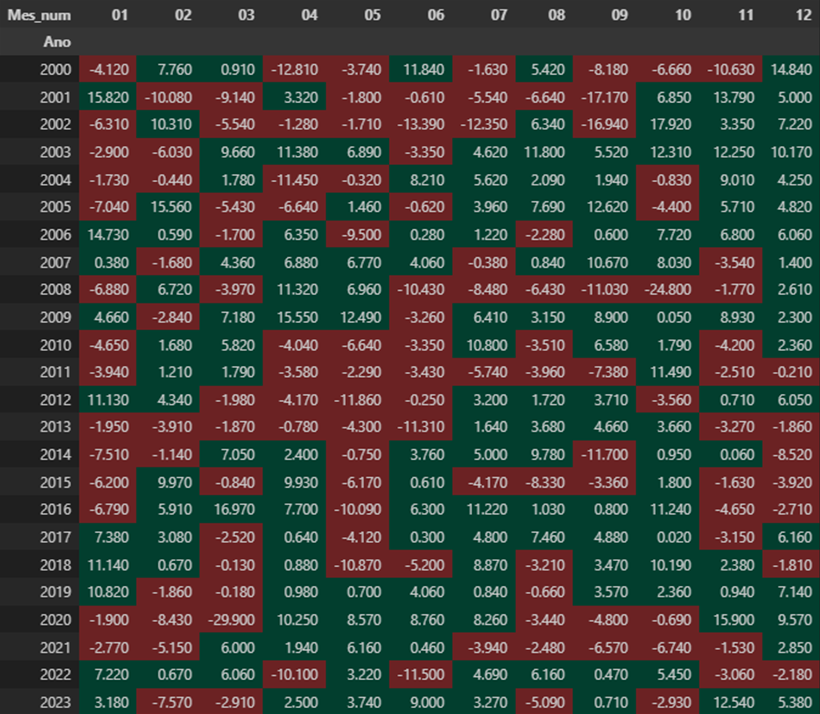
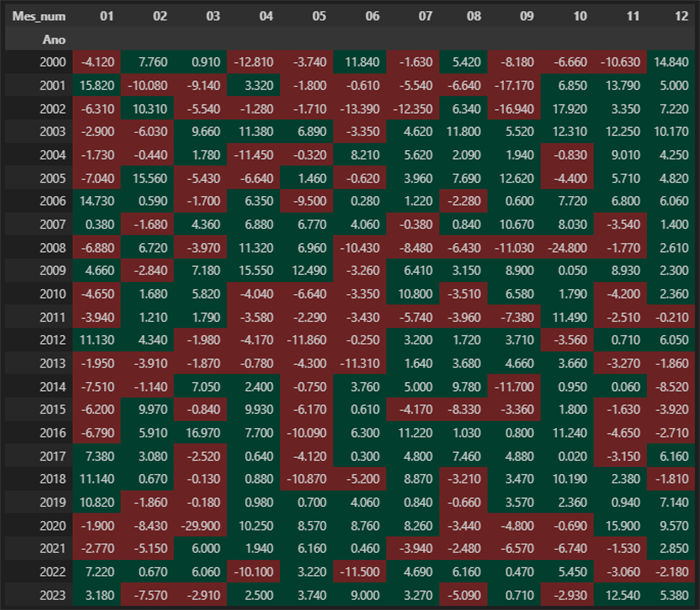
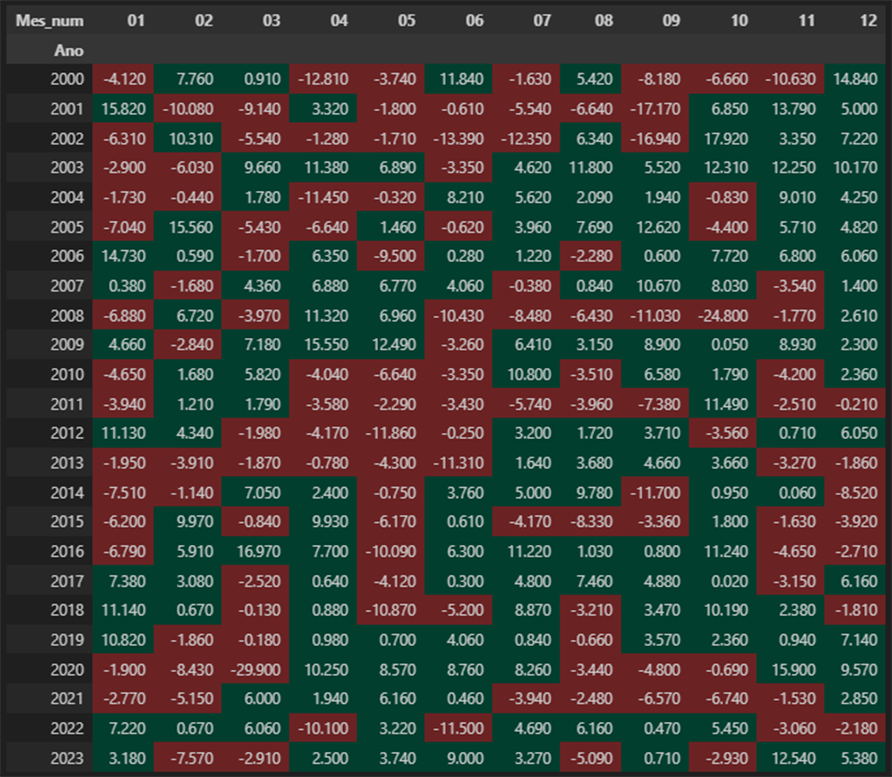
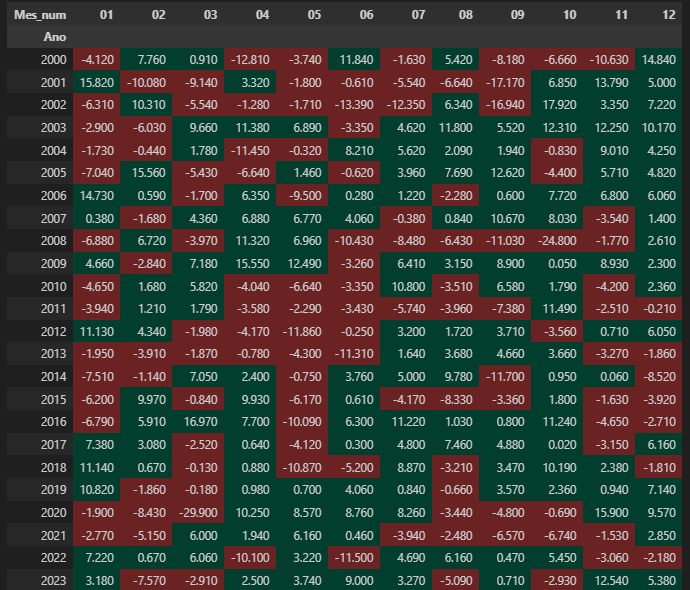
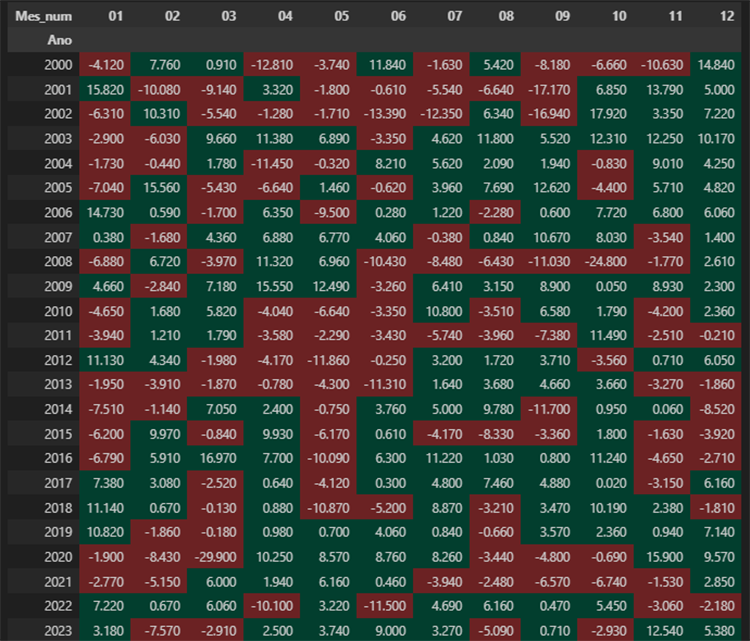
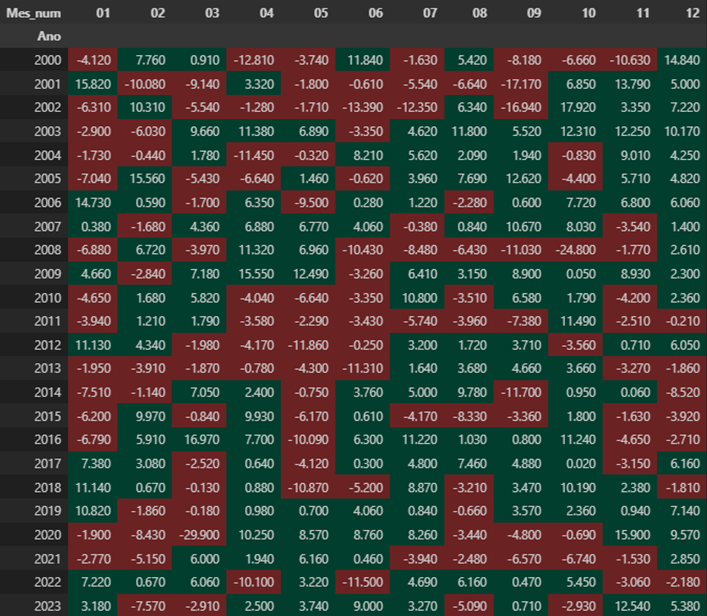
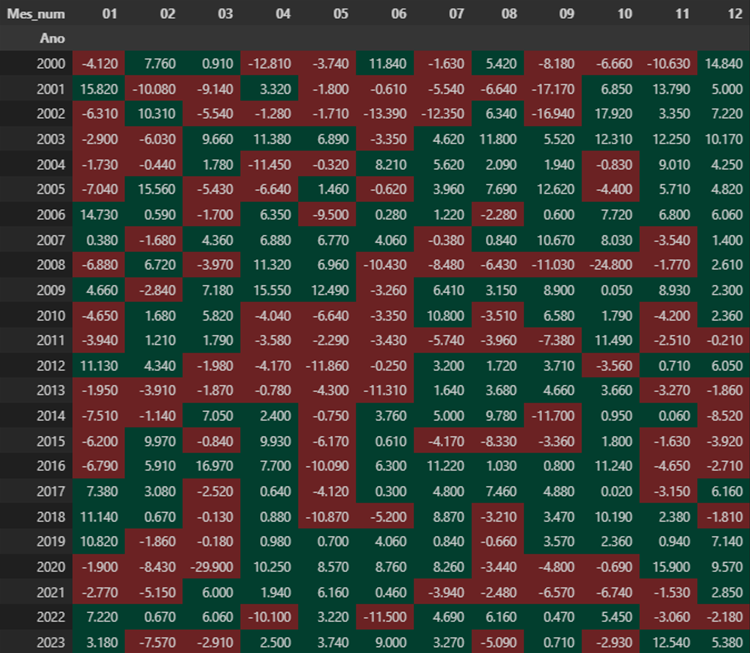
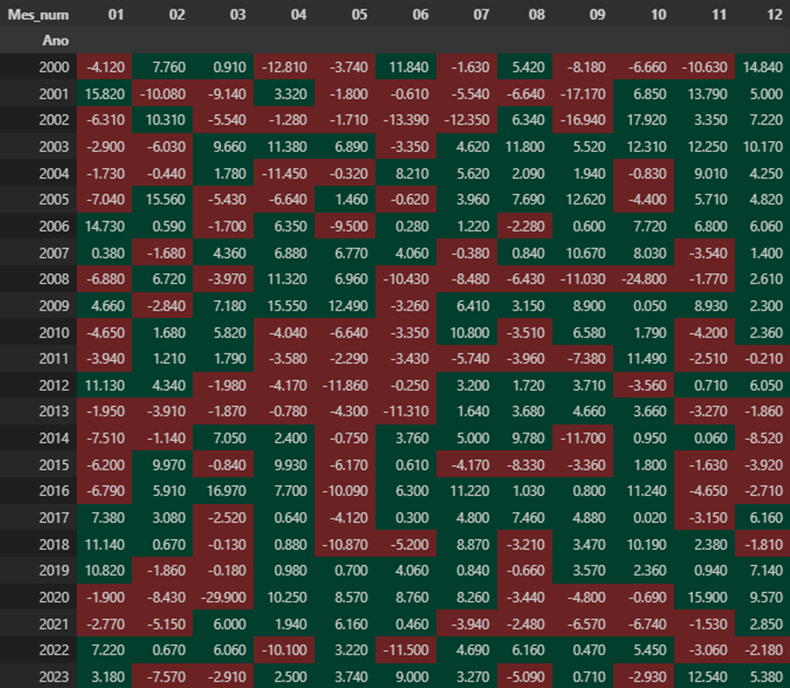
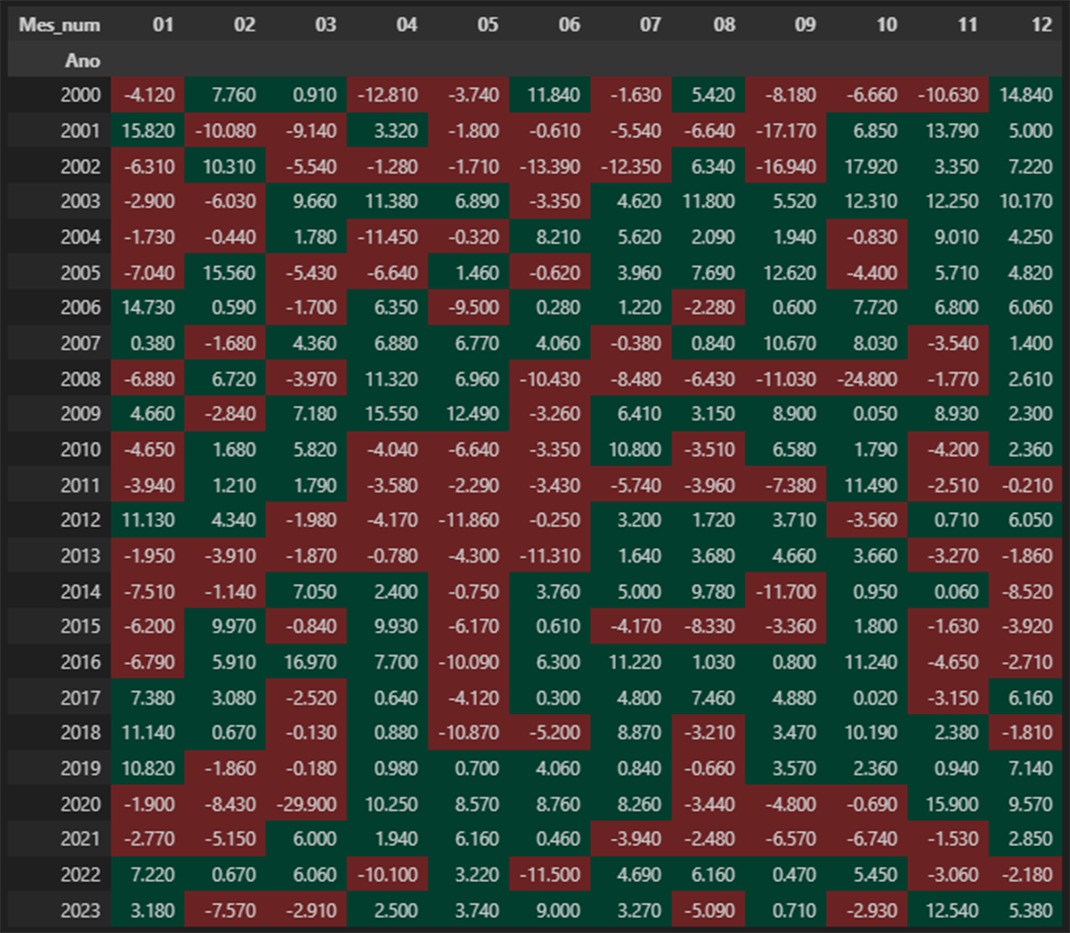

Normalidade dos dados por grupo

- Checar a premissa de normalidade dos dados de cada grupo
- Groupby incluindo uma função lambda
- Agrupar os dados de retornos por mês e aplicar a função do teste de normalidade, retornando apenas o p valor

In [ ]:
pvalor_normalidade = ibov_ohlc[['Mes_num','Resultado_mes']].groupby('Mes_num').agg(lambda x: stats.normaltest(x).pvalue)
pvalor_normalidade

Apesar de haverem outros outliers, antes do teste de normalidade foram removidos os resultados da crise de 2020, ano do "Covid": (-24.8) e ano da crise de 2008 ("Subprimes)

In [ ]:
mar = ibov_ohlc[ibov_ohlc.Mes=='March']
stats.normaltest(mar[mar.Ano!=2020]['Resultado_mes'])

Filtrar os dados de outubro e ver se retirando o dado de 2008 (Subprimes) os dados apresentam distribuição normal

In [ ]:
out = ibov_ohlc[ibov_ohlc.Mes=='October']
stats.normaltest(out[out.Ano!=2008]['Resultado_mes'])

Retirando os anos de 2008 e 2020 para todos os meses

In [ ]:
ibov_ohlc_sem_crises = ibov_ohlc[~ibov_ohlc.Ano.isin([2008, 2020])]
ibov_ohlc_sem_crises

Aplicando o mesmo teste acima, vemos que agora todos os dados estão normais

In [ ]:
pvalor_normalidade = ibov_ohlc_sem_crises[['Mes_num','Resultado_mes']].groupby('Mes_num').agg(lambda x: stats.normaltest(x).pvalue)
pvalor_normalidade

Aplicando os filtros no dataframe (query) para Teste de Levene (homocedasticidade)

In [ ]:
jan = ibov_ohlc_sem_crises.query("Mes in 'January'")['Resultado_mes']
fev = ibov_ohlc_sem_crises.query("Mes in 'February'")['Resultado_mes']
mar = ibov_ohlc_sem_crises.query("Mes in 'March'")['Resultado_mes']
abr = ibov_ohlc_sem_crises.query("Mes in 'April'")['Resultado_mes']
mai = ibov_ohlc_sem_crises.query("Mes in 'May'")['Resultado_mes']
jun = ibov_ohlc_sem_crises.query("Mes in 'June'")['Resultado_mes']
jul = ibov_ohlc_sem_crises.query("Mes in 'July'")['Resultado_mes']
ago = ibov_ohlc_sem_crises.query("Mes in 'August'")['Resultado_mes']
setem = ibov_ohlc_sem_crises.query("Mes in 'September'")['Resultado_mes'] # set já é uma palavra reservada no python
out = ibov_ohlc_sem_crises.query("Mes in 'October'")['Resultado_mes']
nov = ibov_ohlc_sem_crises.query("Mes in 'November'")['Resultado_mes']
dez = ibov_ohlc_sem_crises.query("Mes in 'December'")['Resultado_mes']

Assim como no teste de normalidade, H0 > 0.05 é de que as variâncias são homogenêas

In [ ]:
stats.levene(jan, fev, mar, abr, mai, jun, jul, ago, setem, out, nov, dez)

* Hipótese H0 (nula): As médias dos retornos mensais são iguais estatisticamente entre os meses do ano
* Hipótese H1 (alternativa): As médias são diferentes estatisticamente

Na linha de código: "dv='Resultado_mes', within='Mes', subject='Ano', detailed=True"

- 'dv' será a variável resposta, no caso, retornos mensais  
- 'within' indica os grupos a serem comparados (passado como lista, se dois itens teríamos uma "two way anova de medidas repetidas")  
- 'subject' indica o fator de dependencia, nosso caso o Ano

In [ ]:
anova_medidas_rep = pg.rm_anova(data=ibov_ohlc_sem_crises, dv='Resultado_mes', within='Mes', subject='Ano', detailed=True)
anova_medidas_rep

Tabela dinâmica com a média e erro padrão da média para jogar na figura

In [ ]:
dados_media = ibov_ohlc_sem_crises[['Mes_num','Resultado_mes']].groupby(['Mes_num']).mean()
dados_sem = ibov_ohlc_sem_crises[['Mes_num','Resultado_mes']].groupby(['Mes_num']).std()
dados_figura = pd.concat([dados_media, dados_sem], axis=1)
dados_figura.columns = ['Media_retornos', 'SEM_retornos']

fig = go.Figure()

fig.add_trace(go.Bar(name='Retornos', x=dados_figura.index, y=dados_figura.Media_retornos,
                     error_y=dict(type='data', array=dados_figura.SEM_retornos),
                     marker_color='orange', orientation='v'))

fig.update_layout(title_text='<b>Retornos mensais do IBOV</b> (média \xB1 desvio padrão) <br><b>desde 2000', xaxis_title= '<b>Mês',
                  yaxis_title= '<b>Retorno médio mensal (%)', template="none", margin=dict(l=75, r=20, t=75, b=75),
                  paper_bgcolor="#f7f8fa", font=dict(family="Arial", size=13, color="black"), width=800, height=400)

fig.show()

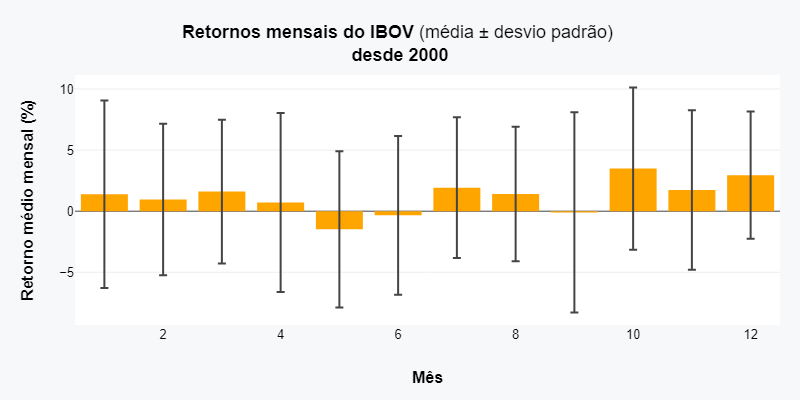

Teste Post-Hoc

In [ ]:
df_post_hoc = pg.pairwise_tests(data=ibov_ohlc, dv='Resultado_mes', within='Mes', subject='Ano')

display(df_post_hoc)

In [ ]:
df_post_hoc[df_post_hoc['p-unc']<0.05]

- depvar será nossa variável resposta, no caso, retornos mensais
- subject indica o fator de dependencia, nosso caso o Ano
- within indica os grupos a serem comparados  
(passado como lista - se dois itens teríamos uma "two way anova de medidas repetidas)

In [ ]:
df_ANOVA = pg.rm_anova(data=ibov_ohlc_sem_crises.query("Mes in ['March', 'May', 'October', 'December']"), dv='Resultado_mes', within='Mes', subject='Ano', detailed=True)
df_ANOVA

---


# <strong><span style="font-size: 30px;">**Conclusões**</span></strong>

# <strong><span style="font-size: 25px;">**Santa Claus Rally:**</span></strong>

<span style="font-size: 22px;">O "Santa Claus Rally" refere-se ao aumento dos preços das ações nos últimos dias de dezembro e nos primeiros dias de janeiro. Para corroborar esse efeito, buscamos evidências de que dezembro e/ou janeiro apresentam retornos superiores e estatisticamente significativos em comparação com outros meses.</span>

<span style="font-size: 23px;"><strong>**Corroborado pelo fato de dezembro apresentar retornos significativamente diferentes e superiores quando comparado a outros meses, como junho e maio.**</span></strong>

# <strong><span style="font-size: 25px;">**Efeito Janeiro:**</span></strong>

<span style="font-size: 23px;">O "Efeito Janeiro" sugere que janeiro tende a ter um desempenho mais forte em comparação com outros meses do ano.</span>

<span style="font-size: 23px;">**Não foi corroborado de forma tão clara, uma vez que janeiro não se destacou significativamente em comparação com outros meses nas análises post-hoc.**</span></strong>

<span style="font-size: 22px;"> • ANOVA de Medidas Repetidas (meses específicos):
Na análise ANOVA focada em março, maio, outubro e dezembro, o resultado foi significativo (p-unc = 0.042137). Isso sugere que entre esses meses, há diferenças estatisticamente significativas nos retornos.</span> 

<span style="font-size: 22px;"> • Teste Post-Hoc:
Para janeiro especificamente, não houve resultados no teste post-hoc que indicassem uma diferença significativa com outros meses. Isso pode sugerir que o "Efeito Janeiro" não é tão forte ou universal quanto o "Santa Claus Rally" no contexto analisado, ou pode não se manifestar de maneira tão clara em comparação direta com outros meses no período estudado.</span>